In [1]:
%load_ext autoreload
%autoreload 2



In [2]:

import gym
import jax
import jax.numpy as jnp
import chex
import numpy as np
from flax import struct
from functools import partial
from typing import Optional, Tuple, Union, Any, Dict
from craftax.craftax_env import make_craftax_env_from_name
from craftax.craftax.play_craftax import CraftaxRenderer
from craftax.craftax.renderer import render_craftax_pixels, render_craftax_text, inverse_render_craftax_symbolic
from craftax.craftax.constants import Action
from craftax.craftax.craftax_state import EnvState
from gymnasium.wrappers import FrameStackObservation, TimeLimit
from gymnax.wrappers import GymnaxToGymWrapper
import torch
from jaxtyping import Float
from torch import Tensor

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Loading textures from cache


In [3]:
from twm.envs.craftax import create_craftax_env

In [7]:
envs = create_craftax_env("Craftax-Symbolic-v1", num_envs=1, eval=True)
obs = envs.reset()[0]

In [31]:
obs.shape
recon_img.shape
o1.shape

torch.Size([4, 130, 110, 3])

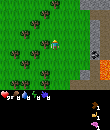

In [35]:
import torchvision
from twm import utils
from twm.envs.craftax import (
    create_craftax_env,
    craftax_symobs_to_img,
    create_vector_env,
    NoAutoReset,
)
o1 = craftax_symobs_to_img(obs.squeeze(1), envs.unwrapped.env_state)
o = o1[-1:].permute(0, 3, 1, 2) / 255.
recon_img = torchvision.utils.make_grid(o, nrow=1, padding=2)
recon_img = utils.to_image(recon_img)
recon_img

In [34]:
o1

tensor([[[[ 17, 144,  22],
          [ 17, 144,  22],
          [ 17, 144,  22],
          ...,
          [137, 139, 143],
          [107, 109, 114],
          [ 88,  89,  94]],

         [[ 17, 144,  22],
          [ 18, 122,   8],
          [ 17, 144,  22],
          ...,
          [107, 109, 114],
          [115, 117, 122],
          [131, 132, 137]],

         [[ 17, 144,  22],
          [ 18, 122,   8],
          [ 24, 170,   6],
          ...,
          [128, 130, 134],
          [127, 129, 134],
          [127, 129, 134]],

         ...,

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
         

In [ ]:
wandb.Image(recon_img)

In [7]:
envs = create_craftax_env("Craftax-Symbolic-v1", num_envs=2, eval=True)
envs.reset()[0].shape

AssertionError: 

In [ ]:
envs = create_craftax_env("Craftax-Symbolic-v1", num_envs=1, eval=False)
envs.reset()[0].shape

In [ ]:
envs = create_craftax_env("Craftax-Symbolic-v1", num_envs=2, eval=False)
envs.reset()[0].shape

### Scratch

In [ ]:
from twm.envs.craftax import CraftaxCompatWrapper, CraftaxRenderWrapper  , OptimisticResetVecEnvWrapper, BatchEnvWrapper, LogWrapper, PermuteObsWrapper, permute_env
from gymnax.wrappers import GymnaxToGymWrapper, GymnaxToVectorGymWrapper


# class PermuteObs(TransformObservation):
#     def __init__(self, env: gym.Env, permutation: Tuple[int, ...]):
#         self.permutation = permutation
#         super().__init__(env)

#     def observation(self, observation: np.ndarray) -> np.ndarray:
#         return observation.transpose(self.permutation)

#     def observation_space(self, observation_space: gym.Space) -> gym.Space:
#         return gym.spaces.Box(
#             low=np.moveaxis(observation_space.low, self.permutation, range(len(self.permutation))),
#             high=np.moveaxis(observation_space.high, self.permutation, range(len(self.permutation))),
#             dtype=observation_space.dtype,
#         )

#     def observation_space(self, observation_space: gym.Space) -> gym.Space:
#         return gym.spaces.Box(
#             low=np.moveaxis(observation_space.low, self.permutation, range(len(self.permutation))),
#             high=np.moveaxis(observation_space.high, self.permutation, range(len(self.permutation))),
#             dtype=observation_space.dtype,
#         )

#     def observation(self, observation: np.ndarray) -> np.ndarray:
#         return observation.transpose(self.permutation)

def create_craftax_env(game, noop_max=30, frame_skip=4, frame_stack=4, frame_size=84,
                     episodic_lives=True, grayscale=True, time_limit=27000, seed=42, eval=False, num_envs=1):
    """
    Craftax with
    - frame_stack 4?
    time_limit = 27000
    
    """
    game = "Craftax-Symbolic-v1"
    # see https://github.dev/MichaelTMatthews/Craftax_Baselines/blob/main/ppo_rnn.py
    # env = make_craftax_env_from_name(game, auto_reset=eval)
    env = make_craftax_env_from_name(game, auto_reset=True)
    # env = LogWrapper(env)
    # if not eval:
    #     env = OptimisticResetVecEnvWrapper(
    #         env,
    #         num_envs=num_envs,
    #         reset_ratio=min(not eval, True),
    #     )
    # else:
    #     env = BatchEnvWrapper(env, num_envs=num_envs)
    env = GymnaxToVectorGymWrapper(env, seed=seed, num_envs=num_envs) 
    # FIXME: sort this out
    env = CraftaxRenderWrapper(env, render_method=None)
    env = CraftaxCompatWrapper(env)

    # We have to vectorise using jax earlier as there is not framestack wrapepr avaiable for jax
    # but then the framestack dim is before the env dim [framestack, batch, obs_dim] so lets swap those
    env = gym.wrappers.FrameStack(env, frame_stack)
    env = permute_env(env, [1, 0, 2])
    
    # env = make_craftax_env_from_name(game, auto_reset=True)
    # env = Gymax2GymWrapper(env, render_method=None)
    
    env.unwrapped.spec = gym.spec(game) # required for AtariPreprocessing
    env = gym.wrappers.TimeLimit(env, max_episode_steps=time_limit)
    return env


envs = create_craftax_env("Craftax-Symbolic-v1", num_envs=2, eval=True)
envs

In [ ]:
envs.step(0)

# with traine

self = trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

trainer._pretrain()
eval_metrics = trainer._evaluate(is_final=False)

In [ ]:
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
rngs = jax.random.split(_rng, 3)

# Create environment
env = make_craftax_env_from_name("Craftax-Symbolic-v1", auto_reset=True)
env_params = env.default_params

# Get an initial state and observation
obs, state = env.reset(rngs[0], env_params)

# Pick random action
action = env.action_space(env_params).sample(rngs[1])

# Step environment
obs, state, reward, done, info = env.step(rngs[2], state, action, env_params)

In [ ]:
env.observation_space(1).dtype

In [ ]:
obs[(obs<1) & (obs>0)]

In [ ]:
action

In [ ]:
reward, done, info